In [274]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from keras.preprocessing import image
from scipy import spatial

# 8.1 Prepare features

### 8.1.1

In [275]:
def nn_interpolation(src,tile_size = (10,10)):
    
    # preprocessing
    feature_shape = (int(src.shape[0]/tile_size[0]),int(src.shape[1]/tile_size[1]),3)
    image_feature =  np.zeros(feature_shape)
    
    # interpolate
    for i in range(image_feature.shape[0]):
        for j in range(image_feature.shape[1]):
            image_feature[i][j] = src[i*tile_size[0] : (i+1)*tile_size[0], j*tile_size[1] : (j+1)*tile_size[1]].mean(axis=(0,1))
    # [:10, :10].mean()    10 x 10 top left
    # [:10, 10:20].mean()  10 x 10 top left shift right 10 px
    # [:10, 20:30].mean()  10 x 10 top left shift right 20 px
    return image_feature.astype(int)

In [276]:
img = cv2.imread('kaimuk.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
tile_size = (50, 50) # 50 , 50
featured = nn_interpolation(src = img, tile_size = tile_size)

In [277]:
img.shape

(704, 564, 3)

In [278]:
featured.shape

(14, 11, 3)

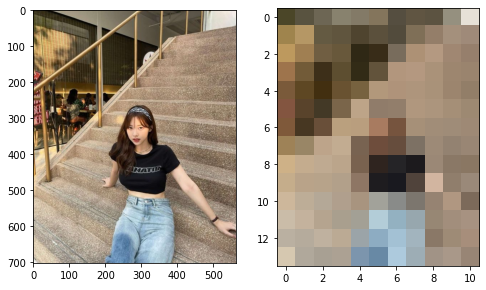

In [279]:
fig, axes = plt.subplots(1,2,figsize=(8,8))
axes[0].imshow(img)
axes[1].imshow(featured)
plt.show()

### 8.1.2

In [280]:
from tensorflow.keras.utils import load_img, img_to_array

paths_background = glob.glob('./Background/*.jpg') # lib of get file names

In [281]:
paths_background[:5]

['./Background\\pexels-abdullah-ghatasheh-1631677.jpg',
 './Background\\pexels-aleksandar-pasaric-3310691.jpg',
 './Background\\pexels-andy-vu-3244513.jpg',
 './Background\\pexels-anna-shvets-3683056.jpg',
 './Background\\pexels-anna-shvets-4611961.jpg']

In [282]:
tiles = []
print(tile_size)
for path in paths_background[:100]:
    tiles.append(img_to_array((load_img(path, target_size = tile_size))).astype(int))

(50, 50)


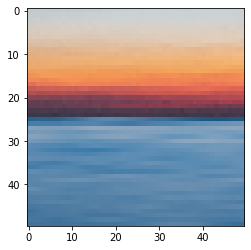

In [283]:
plt.imshow(tiles[0])

In [284]:
tile_features = []
for tile in tiles:
    print(tile)
    tile_features.append(np.array(tile).mean(axis=(0,1))) # mean of 1 tile for find feature

[[[192 203 207]
  [192 203 207]
  [192 203 207]
  ...
  [200 209 214]
  [200 209 214]
  [199 209 211]]

 [[197 202 205]
  [197 202 205]
  [197 202 205]
  ...
  [203 208 211]
  [203 208 211]
  [202 207 210]]

 [[202 204 203]
  [203 205 204]
  [204 206 205]
  ...
  [208 210 209]
  [207 209 208]
  [207 209 208]]

 ...

 [[ 70 118 156]
  [ 69 117 155]
  [ 70 118 156]
  ...
  [ 81 125 164]
  [ 82 126 165]
  [ 82 126 163]]

 [[ 74 119 158]
  [ 72 117 156]
  [ 70 118 156]
  ...
  [ 71 120 160]
  [ 73 121 161]
  [ 75 123 163]]

 [[ 64 116 155]
  [ 63 115 154]
  [ 62 114 154]
  ...
  [ 57 111 155]
  [ 56 110 154]
  [ 56 110 154]]]
[[[254 218   0]
  [254 218   0]
  [254 218   2]
  ...
  [247 201   1]
  [247 201   1]
  [247 201   1]]

 [[254 218   0]
  [254 219   3]
  [245 197  63]
  ...
  [245 202   1]
  [248 203   0]
  [247 201   1]]

 [[254 218   0]
  [254 218   0]
  [253 201  63]
  ...
  [248 203   0]
  [247 201   1]
  [247 201   1]]

 ...

 [[247 198  35]
  [244 182  11]
  [121  46   6]
  ..

In [285]:
tile_features[:5]

[array([145.432 , 143.5532, 151.6692]),
 array([234.4832, 185.5352,  11.3688]),
 array([71.4064, 59.8496, 54.4568]),
 array([249.0892, 220.6068, 148.8084]),
 array([206.4292, 175.4972, 177.3308])]

# 8.2 Image Clustering

In [286]:
k = 1
tree = spatial.KDTree(tile_features)

In [287]:
closest_tiles = np.zeros((featured.shape[0],featured.shape[1])) # size of image with blur already (14, 11, 3)
_h, _w, _ = featured.shape

for i in range(_h):
    for j in range(_w):
        closest = tree.query(featured[i, j], k = k) # k mean how many group (?)
        closest_tiles[i, j] = closest[1] # image for index 1 is the index of picture

In [288]:
closest_tiles = closest_tiles.astype(int)
closest_tiles.shape

(14, 11)

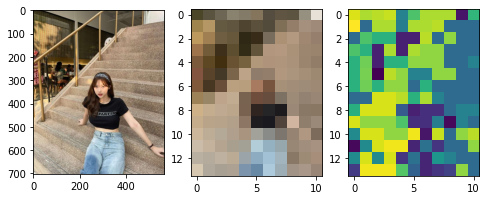

In [289]:
fig, axes = plt.subplots(1,3,figsize=(8,8))
axes[0].imshow(img)
axes[1].imshow(featured)
axes[2].imshow(closest_tiles)
plt.show()

# 8.3 Mosaic

In [290]:
used_img = np.array(img) # clone img to used_img 

# feature shape (14, 11, 3) -> _h _w _
for i in range(_h):
    for j in range(_w):
        x_img, y_img = i * tile_size[0], j * tile_size[1] # tile size offset
        index = closest_tiles[i,j] # index of background pictures
        used_img[x_img:(x_img + tile_size[0]), y_img:(y_img + tile_size[1]), : ] = tiles[index] # assign tile image to location

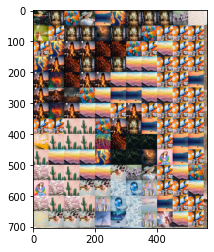

In [291]:
plt.imshow(used_img)

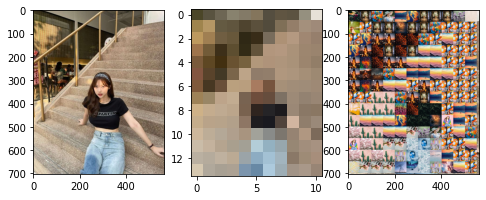

In [292]:
fig, axes = plt.subplots(1, 3, figsize=(8, 8))
axes[0].imshow(img)
axes[1].imshow(featured)
axes[2].imshow(used_img) # zoom out to see mozaic
plt.show()